# Deep Learning (Fall 1401 - Dr. Beigy)

Name: Hamidreza Amirzadeh
</br>
Student Number: 401206999

<div style="direction:rtl;line-height:200%;"><font face="B Nazanin" size=5>
<p>
توجه: این تمرین با همفکری دانشجو آقای علی عبداللهی انجام شده است.
</p>

# 0. Pre

## Introduction
The purpose of this notebook is to teach you some essentials about the Pytorch library. We will also implement our own dataloader, model, and trainer, so that after we train the model, it can distinguish between different cloths! The good news is, if you do this notebook carefully and appropriately, you will have a nice snippet-base to use later on. So let's start `shift+Enter`ing :)

## Requirements

In [484]:
# !pip install -q numpy torch torchvision pillow tqdm

## Imports

In [2]:
from copy import deepcopy
from math import ceil

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

c:\Users\Hamidreza\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


# 1. Data

## Dataset and Dataloader

### Dataset
We will use Fashion-MNIST dataset for our experiments in this notebook. It is a small dataset, so you will not need a GPU for your training.

In [3]:
# Making datasets
train_set = FashionMNIST(root='fashion-mnist', download=True, train=True)
test_set = FashionMNIST(root='fashion-mnist', download=True, train=False)

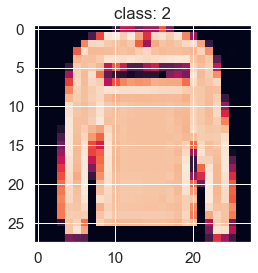

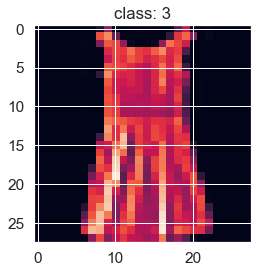

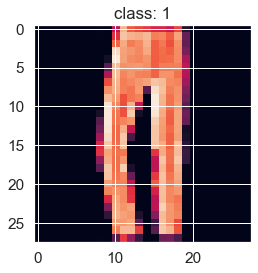

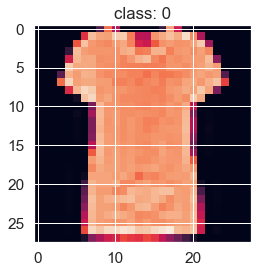

In [487]:
# Testing samples
######################   TODO 1.1   #########################

import matplotlib.pyplot as plt
import random

def plot_sample(data, size):
    samples = random.sample(range(len(data)),size)
    for i in range(size):
        index = samples[i]
        plt.imshow(data.data[index])
        plt.title(f'class: {train_set.targets[index]}')
        plt.show()

plot_sample(train_set,4)

###################### (5 points) #########################

### Dataloader
Dataloader is an object that combines a dataset and a sampler, and provides an iterable over the given dataset. Pytorch has its own dataloader, but here, to understand what lies under the hood, we will implement our custom one.

In [4]:
class CustomDataloader:
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        # images passed to the dataloader are PIL objests.
        # we need to convert those to tensors:
        self.transform = transforms.Compose([
            transforms.PILToTensor()
        ])
        
    def __len__(self):
        ######################   TODO 1.2   ########################
        # return the count of batches.
        return ceil(len(self.dataset)/self.batch_size)
        ###################### (1 points) #########################

    def __iter__(self, calm=True):
        indexes = list(range(len(self.dataset)))
        if self.shuffle:
            np.random.shuffle(indexes)

        for idx in range(0, len(self.dataset), self.batch_size):
            ######################   TODO 1.3   ########################

            batch_imgs_transformed = []
            batch_labels = []
            
            batch_indexes = list(range(idx, min(idx+self.batch_size, len(self.dataset))))
            
            for i in batch_indexes:
                batch_imgs_transformed.append((self.transform(self.dataset[indexes[i]][0])/255).to(torch.float32))
                batch_labels.append(self.dataset.targets[indexes[i]])

            ###################### (8 points) #########################
            yield torch.stack(batch_imgs_transformed), torch.tensor(batch_labels)
        return


In [489]:
def test_dataloader():
    ######################   TODO 1.3   ########################
    # test your dataloader! 
    dataloader = CustomDataloader(train_set,256, True)
    for data, labels in dataloader:
        print(data)
        print(labels)
        break
    ###################### (5 points) #########################

test_dataloader()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [490]:
######################   TODO 1.4   #########################

batch_size = 64
shuffle = True
train_dataloader = CustomDataloader(train_set, batch_size, shuffle)
test_dataloader = CustomDataloader(test_set, batch_size, shuffle)

###################### (1 points) #########################

# 2. Model
Here, we will implement our network. Our model is a simple feed-forward network that gets an image, flattens the image, then passes it through several linear layers with relu activations.

In [5]:
class Classifier(nn.Module):
    def __init__(self, input_dims, hidden_dims, num_classes):
        super().__init__()
        self.nn_layers = nn.ModuleList()
        self.activation = nn.ReLU()
        self.flatten = torch.flatten
        ######################   TODO 2.1   #######################
        
        if len(hidden_dims) != 0:
            self.nn_layers.append(nn.Linear(input_dims[0]*input_dims[1], hidden_dims[0]))
            for i in range(len(hidden_dims)-1):
                self.nn_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.nn_layers.append(nn.Linear(hidden_dims[-1], num_classes))
        else:
            self.nn_layers.append(nn.Linear(input_dims[0]*input_dims[1], num_classes))

        ###################### (10 points) #########################
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x, start_dim=1)
        ######################   TODO 2.2   ########################

        for i in range(len(self.nn_layers)-1):
            x = self.nn_layers[i](x)
            x = self.activation(x)
        x = self.nn_layers[-1](x)

        ###################### (5 points) #########################
        return x

    def predict(self, x):
        ######################   TODO 2.3   ########################

        x = self.forward(x)
        x = self.softmax(x)
        prediction = torch.argmax(x, dim=1)
        
        ###################### (5 points) #########################
        return prediction


In [492]:
def test_model():
    input_dims = (28, 28)
    hidden_dims = [10, 100, 20]
    num_classes = 10
    batch_size = 8
    
    cls = Classifier(input_dims, hidden_dims, num_classes)
    x = torch.rand(batch_size, *input_dims)
    assert cls(x).shape == torch.Size([batch_size, num_classes])
    assert cls.predict(x).shape == torch.Size([batch_size])


def test_model_with_dataloader():
    input_dims = (28, 28)
    hidden_dims = [10, 100, 20]
    num_classes = 10
    batch_size = 8
    dataloader = CustomDataloader(dataset=test_set, batch_size=batch_size, shuffle=True)
    imgs, labels = next(iter(dataloader))
    cls = Classifier(input_dims, hidden_dims, num_classes)
    assert cls(imgs).shape == torch.Size([batch_size, num_classes])
    assert cls.predict(imgs).shape == torch.Size([batch_size])

test_model()
test_model_with_dataloader()

# 3. Training

## Trainer
Trainer is an object that gets the model, dataloaders, optimizer and criterion and then trains the model with the given data in a training loop. 

In [6]:
class Trainer:
    def __init__(self, 
        train_dataloader, val_dataloader, model,
        optimizer, criterion, *args, **kwargs
    ):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.best_model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_losses = []
        self.val_losses = []
        self.val_loss = None
        self.min_val_loss = np.inf
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def train(self, epochs, log_each_n_percent_epoch):
        train_steps = len(self.train_dataloader)
        log_steps = int(train_steps * log_each_n_percent_epoch/100)

        self.model.train()

        for epoch in range(epochs):
            print(f"epoch {epoch+1} started".title().center(50, "="))
            train_loss = 0.0
            listLoss = []
            for step, (data, labels) in tqdm(enumerate(self.train_dataloader)):
                ######################   TODO 3.1   ########################

                data, labels = data.to(self.device), labels.to(self.device)
                labels_pred = self.model(data)
                loss = self.criterion(labels_pred, labels)
                listLoss.append(loss.item())
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ###################### (10 points) #########################

                if step % log_steps == 1:
                    self.val_loss, accuracy = self.evaluate(save=True)
                    self.val_losses.append(self.val_loss)
                    self.train_losses.append(np.sum(listLoss)/len(listLoss))
                    listLoss = []
                    info_text = f'Validation Loss: {self.val_loss:.6f}\t Accuracy-score: {accuracy:.2f}'
                    print(info_text)
                    self.post_evaluation_actions()
                    

    def evaluate(self, save=False):
        listLoss =[]
        accuracy = 0
        with torch.no_grad():
            y_true, y_pred = [], []
            ######################   TODO 3.2   ########################

            for step, (data, labels) in tqdm(enumerate(self.val_dataloader)):
                data, labels = data.to(self.device), labels.to(self.device)
                labels_pred = self.model(data)
                loss = self.criterion(labels_pred, labels)
                labels_pred_index = self.model.predict(data)
                listLoss.append(loss.item())
                list_Y = labels.tolist()
                list_Predict_Y = labels_pred_index.tolist()
                for i in range(len(list_Y)):
                    y_true.append(list_Y[i])
                    y_pred.append(list_Predict_Y[i])
                
            val_loss = np.sum(listLoss)
            joint = list(zip(y_true, y_pred))
            accuracy = np.mean([l1==l2 for (l1,l2) in joint])
            
            ###################### (5 points) #########################
            self.val_losses.append(val_loss)
            return val_loss, accuracy
            

    def confusionMatrix(self):
        y_true, y_pred = [], []
        for step, (data, labels) in tqdm(enumerate(self.val_dataloader)):
            data, labels = data.to(self.device), labels.to(self.device)
            labels_pred = self.model(data)
            labels_pred_index = self.model.predict(data)
            list_Y = labels.tolist()
            list_Predict_Y = labels_pred_index.tolist()
            for i in range(len(list_Y)):
                y_true.append(list_Y[i])
                y_pred.append(list_Predict_Y[i])
        y_true = pd.Series(y_true, name='Actual')
        y_pred = pd.Series(y_pred, name='Predicted')
        confusion = confusion_matrix(y_true, y_pred)
        print("confusion matrix :")
        print(confusion)
        confusion = np.log(confusion)
        print("log of confusion matrix :")

        
    def plotLoss(self):
        plt.plot(self.val_losses, color='blue', mfc='red' )
        plt.xticks(range(0,len(self.val_losses)+1, 10)) 

        plt.ylabel('loss val') 
        plt.xlabel('batches') 
        plt.title("validation") 
        plt.show() 
        
        plt.plot(self.train_losses, color='blue',mfc='red' ) 
        plt.xticks(range(0,len(self.train_losses)+1, 10))

        plt.ylabel('loss train') 
        plt.xlabel('batches') 
        plt.title("train") 
        plt.show() 

    def post_evaluation_actions(self):
        pass

## Train

In [494]:
######################   TODO 3.3   #########################

input_dims = (28,28)
hidden_dims = [512,256]
num_classes = 10

model = Classifier(input_dims, hidden_dims, num_classes)

learning_rate = 0.3
optimizer = torch.optim.SGD(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

###################### (5 points) #########################

In [495]:
######################   TODO 3.4   #######################

trainer1 = Trainer(train_dataloader, test_dataloader, model, optimizer, criterion)
trainer1.train(epochs=5, log_each_n_percent_epoch=10)

###################### (5 points) #########################

=================Epoch 1 Started==================



Validation Loss: 351.790588	 Accuracy-score: 0.15



Validation Loss: 114.494232	 Accuracy-score: 0.71



Validation Loss: 100.412155	 Accuracy-score: 0.76



Validation Loss: 90.355225	 Accuracy-score: 0.79



Validation Loss: 97.528458	 Accuracy-score: 0.76



Validation Loss: 93.647690	 Accuracy-score: 0.77



Validation Loss: 73.887222	 Accuracy-score: 0.83



Validation Loss: 80.769913	 Accuracy-score: 0.81



Validation Loss: 76.598900	 Accuracy-score: 0.82



Validation Loss: 77.074051	 Accuracy-score: 0.81



Validation Loss: 70.498634	 Accuracy-score: 0.84

=================Epoch 2 Started==================



Validation Loss: 71.950546	 Accuracy-score: 0.84



Validation Loss: 68.893707	 Accuracy-score: 0.83



Validation Loss: 65.893219	 Accuracy-score: 0.85



Validation Loss: 69.333458	 Accuracy-score: 0.84



Validation Loss: 68.813705	 Accuracy-score: 0.83



Validation Loss: 63.594498	 Accuracy-score: 0.85



Validation Loss: 61.842384	 Accuracy-score: 0.85



Validation Loss: 62.408997	 Accuracy-score: 0.86



Validation Loss: 65.112778	 Accuracy-score: 0.85



Validation Loss: 62.674164	 Accuracy-score: 0.85



Validation Loss: 60.028332	 Accuracy-score: 0.86

=================Epoch 3 Started==================



Validation Loss: 80.225388	 Accuracy-score: 0.81



Validation Loss: 61.273830	 Accuracy-score: 0.86



Validation Loss: 59.642040	 Accuracy-score: 0.86



Validation Loss: 60.746239	 Accuracy-score: 0.86



Validation Loss: 65.373871	 Accuracy-score: 0.84



Validation Loss: 58.619125	 Accuracy-score: 0.86



Validation Loss: 65.266266	 Accuracy-score: 0.85



Validation Loss: 61.976982	 Accuracy-score: 0.85



Validation Loss: 59.134422	 Accuracy-score: 0.86



Validation Loss: 60.979233	 Accuracy-score: 0.86



Validation Loss: 62.781498	 Accuracy-score: 0.85

=================Epoch 4 Started==================



Validation Loss: 62.983894	 Accuracy-score: 0.84



Validation Loss: 60.768723	 Accuracy-score: 0.86



Validation Loss: 63.540314	 Accuracy-score: 0.85



Validation Loss: 59.337517	 Accuracy-score: 0.86



Validation Loss: 56.351936	 Accuracy-score: 0.87



Validation Loss: 57.032894	 Accuracy-score: 0.87



Validation Loss: 56.743675	 Accuracy-score: 0.87



Validation Loss: 62.019978	 Accuracy-score: 0.85



Validation Loss: 55.794525	 Accuracy-score: 0.87



Validation Loss: 56.666855	 Accuracy-score: 0.86



Validation Loss: 55.972633	 Accuracy-score: 0.87

=================Epoch 5 Started==================



Validation Loss: 61.826424	 Accuracy-score: 0.85



Validation Loss: 60.025391	 Accuracy-score: 0.86



Validation Loss: 60.013618	 Accuracy-score: 0.86



Validation Loss: 55.320538	 Accuracy-score: 0.87



Validation Loss: 54.376602	 Accuracy-score: 0.87



Validation Loss: 56.988014	 Accuracy-score: 0.87



Validation Loss: 60.397823	 Accuracy-score: 0.86



Validation Loss: 53.990685	 Accuracy-score: 0.87



Validation Loss: 59.578472	 Accuracy-score: 0.86



Validation Loss: 54.395565	 Accuracy-score: 0.87



Validation Loss: 55.555748	 Accuracy-score: 0.87



In [496]:
######################   TODO 3.5   #######################

model = Classifier(input_dims, hidden_dims, num_classes)

optimizer = torch.optim.Adagrad(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

trainer2 = Trainer(train_dataloader, test_dataloader, model, optimizer, criterion)
trainer2.train(epochs=5, log_each_n_percent_epoch=10)

###################### (5 points) #########################

=================Epoch 1 Started==================



Validation Loss: 3881996.000000	 Accuracy-score: 0.10



Validation Loss: 182.223846	 Accuracy-score: 0.67



Validation Loss: 151.222168	 Accuracy-score: 0.70



Validation Loss: 128.850937	 Accuracy-score: 0.74



Validation Loss: 116.872559	 Accuracy-score: 0.75



Validation Loss: 107.615532	 Accuracy-score: 0.77



Validation Loss: 120.178947	 Accuracy-score: 0.72



Validation Loss: 99.783493	 Accuracy-score: 0.78



Validation Loss: 103.191048	 Accuracy-score: 0.77



Validation Loss: 98.913300	 Accuracy-score: 0.77



Validation Loss: 96.039276	 Accuracy-score: 0.79

=================Epoch 2 Started==================



Validation Loss: 98.312965	 Accuracy-score: 0.78



Validation Loss: 97.190277	 Accuracy-score: 0.79



Validation Loss: 93.987526	 Accuracy-score: 0.79



Validation Loss: 94.361221	 Accuracy-score: 0.79



Validation Loss: 91.559677	 Accuracy-score: 0.79



Validation Loss: 94.491150	 Accuracy-score: 0.79



Validation Loss: 94.997849	 Accuracy-score: 0.79



Validation Loss: 91.122437	 Accuracy-score: 0.80



Validation Loss: 87.272522	 Accuracy-score: 0.81



Validation Loss: 85.373032	 Accuracy-score: 0.81



Validation Loss: 92.203064	 Accuracy-score: 0.80

=================Epoch 3 Started==================



Validation Loss: 86.502914	 Accuracy-score: 0.81



Validation Loss: 83.140305	 Accuracy-score: 0.82



Validation Loss: 82.758781	 Accuracy-score: 0.82



Validation Loss: 82.957497	 Accuracy-score: 0.82



Validation Loss: 88.065147	 Accuracy-score: 0.81



Validation Loss: 82.189545	 Accuracy-score: 0.82



Validation Loss: 82.451698	 Accuracy-score: 0.82



Validation Loss: 81.438057	 Accuracy-score: 0.83



Validation Loss: 90.368546	 Accuracy-score: 0.80



Validation Loss: 79.996262	 Accuracy-score: 0.83



Validation Loss: 79.817833	 Accuracy-score: 0.83

=================Epoch 4 Started==================



Validation Loss: 79.119812	 Accuracy-score: 0.83



Validation Loss: 79.153687	 Accuracy-score: 0.83



Validation Loss: 93.011353	 Accuracy-score: 0.80



Validation Loss: 78.473480	 Accuracy-score: 0.83



Validation Loss: 77.365799	 Accuracy-score: 0.83



Validation Loss: 77.446434	 Accuracy-score: 0.83



Validation Loss: 77.193039	 Accuracy-score: 0.83



Validation Loss: 76.734978	 Accuracy-score: 0.83



Validation Loss: 74.997025	 Accuracy-score: 0.84



Validation Loss: 78.634171	 Accuracy-score: 0.83



Validation Loss: 74.611237	 Accuracy-score: 0.84

=================Epoch 5 Started==================



Validation Loss: 77.183678	 Accuracy-score: 0.83



Validation Loss: 79.049454	 Accuracy-score: 0.83



Validation Loss: 74.957504	 Accuracy-score: 0.84



Validation Loss: 77.004639	 Accuracy-score: 0.83



Validation Loss: 76.694611	 Accuracy-score: 0.83



Validation Loss: 76.213730	 Accuracy-score: 0.83



Validation Loss: 74.273285	 Accuracy-score: 0.84



Validation Loss: 72.760269	 Accuracy-score: 0.84



Validation Loss: 74.505493	 Accuracy-score: 0.84



Validation Loss: 76.285187	 Accuracy-score: 0.83



Validation Loss: 77.003410	 Accuracy-score: 0.83



## Trainer with Early Stopping
First, feel free to study about Early Stopping technique on the internet. Then come along to the next cell.

In [497]:
class EarlyStppedException(Exception):
    pass


class TrainerWithEarlyStopping(Trainer):
    def  __init__(self, *args, **kwargs):
        ######################   TODO 3.6   #######################

        super().__init__(kwargs.get('train_dataloader'), kwargs.get('val_dataloader'), kwargs.get('model') , kwargs.get('optimizer'), kwargs.get('criterion') )
        self.minLoss = 100
        self.threshold = kwargs.get("treshold")
        self.extraLossSum = 0
        self.thresholdSum = 0.3

        ###################### (3 points) #########################


    def post_evaluation_actions(self):
        ######################   TODO 3.6   #######################

        if self.val_loss > (self.minLoss+self.threshold):
            self.extraLossSum = self.extraLossSum +(self.val_loss - self.minLoss)
            print("extraLossSum:")
            print(self.extraLossSum)
            print("minLoss:")
            print(self.minLoss)
            
        elif self.val_loss < self.minLoss:
            self.minLoss = self.val_loss
        if self.extraLossSum > self.thresholdSum:
            self.best_model = deepcopy(self.model)
            print("end")
            raise EarlyStppedException()

        ###################### (7 points) #########################

In [498]:
######################   TODO 3.6   #######################

trainer3 = TrainerWithEarlyStopping(train_dataloader, test_dataloader, model, optimizer, criterion , threshold =0.03 )
trainer3.train(epochs=5, log_each_n_percent_epoch=10)

###################### ( 0 points) #########################

TypeError: object of type 'NoneType' has no len()

# 4. Plots

**4.1. plot the learning curves for both optimizers.(5 points)**

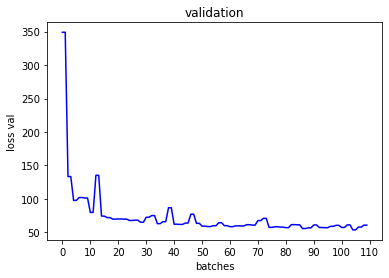

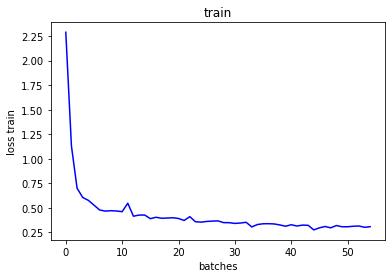

In [ ]:
trainer1.plotLoss()

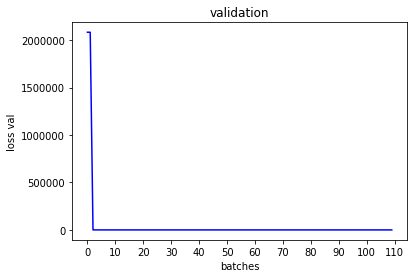

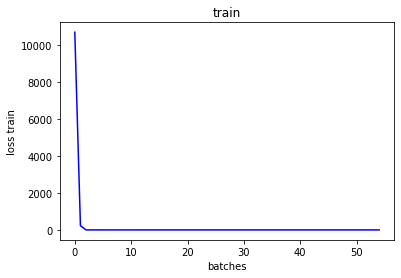

In [ ]:
trainer2.plotLoss()

**4.2. plot the confusion matrix on the test set (5 points)**

In [ ]:
trainer1.confusionMatrix()


confusion matrix :
[[786   1   6  46   5   1 141   0  14   0]
 [  2 959   0  28   5   0   5   0   1   0]
 [ 15   0 525  10 234   1 211   0   4   0]
 [ 13   2   3 888  49   0  38   0   7   0]
 [  0   0  16  22 843   0 117   0   2   0]
 [  0   0   0   0   0 969   0  16   0  15]
 [105   0  26  39  59   0 759   0  12   0]
 [  0   0   0   0   0  39   0 886   1  74]
 [  2   0   0   2   7   2   6   3 978   0]
 [  0   0   0   0   0   7   1  15   0 977]]
log of confusion matrix :


c:\Users\Hamidreza\anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log


In [ ]:
trainer2.confusionMatrix()


confusion matrix :
[[  5   2   0  35 950   1   0   0   6   1]
 [  0 930   0  30  39   0   0   0   1   0]
 [  0   0   0   3 995   1   0   0   1   0]
 [  0   7   0 604 387   0   0   0   2   0]
 [  0   1   0  17 976   0   1   0   5   0]
 [  1   0   0   0  32 801   1 114   4  47]
 [  1   0   0  12 979   0   1   1   6   0]
 [  0   0   0   0   2  15   0 837   0 146]
 [  0   2   0   2 143   0   5   8 838   2]
 [  0   0   0   0  22  11   0  42   0 925]]
log of confusion matrix :


c:\Users\Hamidreza\anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log


# 5. Conclusion

**5.1. what does `torch.no_grad()` do? (5 points)**

<div style="direction:rtl;line-height:200%;"><font face="B Nazanin" size=5>
<p>
با استفاده از این دستور، دیگر عملیات مربوط به مشتق گیری و انتشار به عقب رهگیری نمی شود. بنابراین در زمان ارزیابی و تست مدل که نیازی به انتشار
به عقب و رهگیری مشتق ها نیست، از این دستور استفاده می شود که باعث افزایش سرعت و کاهش هزینه محاسباتی می شود.
</p>

**5.2. what is the diference between `CrossEntropyLoss` and `NLLLOSS`? Could we use `NLLLOSS` instead? How? (5 points)**

<div style="direction:rtl;line-height:200%;"><font face="B Nazanin" size=5>
<p>
تفاوت negative log likelihood loss با CrossEntropyLoss در این است که به جای خروجی سافتمکس،خروجی یک لایه لگاریتمی را می گیرد که بین خروجی سافتمکس و آن قرار دارد.
درواقع می توان گفت که اگر logsoftmax را به NNLOSS اضافه کنیم به همان CrossEntropyLoss می رسیم.
</p>